# Model Parameter Extraction Attack

 This notebook demonstrates how to perform a model parameter extraction attack against a machine learning model available through an API. Unlike basic model stealing that just replicates functionality, parameter extraction attempts to recover the actual parameters and structure of the target model.
### Introduction
Model parameter extraction is a more advanced form of model stealing where an attacker tries to recover the internal parameters (weights and biases) of a target model by observing its inputs and outputs. This type of attack can be particularly concerning for proprietary models as it may reveal intellectual property and implementation details.
Background and Threat Model
In this scenario, we assume the following threat model:

<b>Target Model:</b> A neural network deployed behind an API that accepts input images and returns classification probabilities.

<b>Attacker's Knowledge:</b> Black-box access (can only query the API and observe outputs).

<b>Attacker's Goal:</b> Extract model parameters that closely match the target model's internal architecture.

The attack works by systematically querying the target model, training a surrogate model on the observed input-output pairs, and optimizing the surrogate to mimic the target's behavior as closely as possible.

## 0. Importing Libraries 

In [2]:
import tensorflow as tf
import numpy as np
import requests
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Configure warnings
import warnings
warnings.filterwarnings('ignore')

2025-02-25 01:19:41.246163: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-25 01:19:41.468002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740446381.557343  157165 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740446381.567502  157165 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-25 01:19:41.607198: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## 1. Setting Up the Attack Framework
We create a ServerModelExtractionAttack class that handles querying the target model and setting up our extraction architecture:

In [3]:
class ServerModelExtractionAttack:
    def __init__(self, server_url="http://localhost:5000/predict", input_shape=(28, 28, 1), num_classes=10):
        self.server_url = server_url
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.extraction_model = None
        self.layer_weights = []


In [4]:
def query_server(self, image):
    """Query the server with an image"""
    try:
        response = requests.post(
            self.server_url,
            json={'image': image.reshape(28, 28).tolist()}
        )
        if response.status_code == 200:
            return np.array(response.json()['full_probabilities'])
        else:
            print(f"Server error: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error querying server: {e}")
        return None


## 2. Creating the Surrogate Model Architecture
The key to successful parameter extraction is creating a surrogate model that matches the target's architecture:

In [5]:
def create_extraction_model(self):
    """Create model architecture for extraction"""
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(self.num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    self.extraction_model = model
    return model


### 3. Collecting Training Data from the Target Model
To extract parameters, we need to gather the model's behavior on various inputs:

In [6]:
def collect_server_behavior(self, x_train, batch_size=100):
    """Collect server predictions for training data"""
    print("Collecting server predictions...")
    server_predictions = []
    
    for i in tqdm(range(0, len(x_train), batch_size)):
        batch = x_train[i:i + batch_size]
        batch_predictions = []
        
        for image in batch:
            pred = self.query_server(image)
            if pred is not None:
                batch_predictions.append(pred)
                
        server_predictions.extend(batch_predictions)
        
    return np.array(server_predictions)


### 4. Parameter Extraction Process
The actual extraction is performed by training our surrogate model to mimic the target model's outputs:

In [7]:
def extract_parameters(self, x_train, epochs=10, batch_size=32):
    """Extract model parameters through training"""
    if self.extraction_model is None:
        self.create_extraction_model()
        
    print("Getting server predictions for training...")
    server_predictions = self.collect_server_behavior(x_train[:1000])
    
    print("\nTraining extraction model...")
    history = self.extraction_model.fit(
        x_train[:1000],
        server_predictions,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=1
    )
    
    # Store extracted weights
    self.layer_weights = [layer.get_weights() for layer in self.extraction_model.layers]
    
    return history


### 5. Evaluate Extraction

This method evaluates the success of a model extraction attack by comparing predictions from the target server model with predictions from our extracted model.

In [8]:
def evaluate_extraction(self, x_test, batch_size=32):
    """Evaluate extraction success"""
    print("\nEvaluating extraction...")
    
    # Get predictions from server
    server_predictions = self.collect_server_behavior(x_test[:100])
    
    # Get predictions from extraction model
    extracted_predictions = self.extraction_model.predict(x_test[:100], batch_size=batch_size)
    
    # Calculate agreement rate
    server_classes = np.argmax(server_predictions, axis=1)
    extracted_classes = np.argmax(extracted_predictions, axis=1)
    agreement_rate = np.mean(server_classes == extracted_classes)
    
    # Calculate prediction correlation
    prediction_correlation = np.corrcoef(
        server_predictions.flatten(),
        extracted_predictions.flatten()
    )[0, 1]
    
    return {
        'agreement_rate': agreement_rate,
        'prediction_correlation': prediction_correlation,
        'example_comparisons': list(zip(server_classes[:5], extracted_classes[:5])),
        'server_predictions': server_predictions,
        'extracted_predictions': extracted_predictions
    }


### 6. Visualize Extraction Performance

This method generates visualizations to track the training progress of the model extraction attack, allowing analysts to understand how well the surrogate model is learning to mimic the target model's behavior.



In [9]:
def visualize_extraction(self, history):
    """Visualize extraction performance"""
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Extraction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Extraction Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


### 7. Visualize Prediction Comparisons

This method creates a scatter plot to visually compare predictions between the target server model and the extracted model, providing an intuitive way to assess extraction quality.


In [10]:
def visualize_predictions(self, results):
    """Visualize prediction comparisons"""
    server_preds = results['server_predictions']
    extracted_preds = results['extracted_predictions']
    
    plt.figure(figsize=(10, 5))
    plt.scatter(
        server_preds.flatten(), 
        extracted_preds.flatten(), 
        alpha=0.1
    )
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('Server Predictions')
    plt.ylabel('Extracted Model Predictions')
    plt.title('Prediction Comparison')
    plt.show()


### 8. Analyzing Extracted Parameters
To understand how successful the extraction was, we analyze the parameters:

In [11]:
def analyze_extracted_parameters(self):
    """Analyze extracted model parameters"""
    parameter_analysis = []
    
    for i, weights in enumerate(self.layer_weights):
        if len(weights) > 0:  # Check if layer has weights
            layer_stats = {
                'layer_index': i,
                'layer_type': self.extraction_model.layers[i].__class__.__name__,
                'num_parameters': np.sum([w.size for w in weights]),
                'weight_stats': {
                    'mean': float(np.mean([np.mean(w) for w in weights])),
                    'std': float(np.std([np.std(w) for w in weights])),
                    'min': float(np.min([np.min(w) for w in weights])),
                    'max': float(np.max([np.max(w) for w in weights]))
                }
            }
            parameter_analysis.append(layer_stats)
    
    return parameter_analysis


In [12]:
ServerModelExtractionAttack.query_server = query_server
ServerModelExtractionAttack.create_extraction_model = create_extraction_model
ServerModelExtractionAttack.collect_server_behavior = collect_server_behavior
ServerModelExtractionAttack.extract_parameters = extract_parameters
ServerModelExtractionAttack.evaluate_extraction = evaluate_extraction
ServerModelExtractionAttack.visualize_extraction = visualize_extraction
ServerModelExtractionAttack.visualize_predictions = visualize_predictions
ServerModelExtractionAttack.analyze_extracted_parameters = analyze_extracted_parameters


### 9. Loading Dataset

In [13]:
# Load MNIST data
print("Loading MNIST dataset...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape images
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print("Data shapes:")
print(f"x_train: {x_train.shape}")
print(f"x_test: {x_test.shape}")

Loading MNIST dataset...
Data shapes:
x_train: (60000, 28, 28, 1)
x_test: (10000, 28, 28, 1)


In [14]:
# Initialize attack
attack = ServerModelExtractionAttack()


### 10. Executing Parameter Extraction Attack

This code snippet initiates the core functionality of the model extraction attack:


In [20]:

# Extract parameters
print("Starting parameter extraction attack...")
history = attack.extract_parameters(x_train)




Starting parameter extraction attack...
Getting server predictions for training...


  0%|          | 0/10 [00:00<?, ?it/s]


Training extraction model...
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9968 - loss: 0.0397 - val_accuracy: 0.9250 - val_loss: 0.3197
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9980 - loss: 0.0322 - val_accuracy: 0.9350 - val_loss: 0.2739
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9977 - loss: 0.0273 - val_accuracy: 0.9450 - val_loss: 0.2679
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9991 - loss: 0.0248 - val_accuracy: 0.9400 - val_loss: 0.2829
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9967 - loss: 0.0231 - val_accuracy: 0.9400 - val_loss: 0.2498
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9985 - loss: 0.0214 - val_accuracy: 0.9350 - val_loss: 0.2647
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9954 - loss: 0.0233 - val_accuracy: 0.9400 - val_loss: 0.2583
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 1.0000 - loss: 0.0

### 11. Evaluating Performace of Extracted Model

In [21]:
# Evaluate extraction
results = attack.evaluate_extraction(x_test)

# Print results
print("\nExtraction Results:")
print(f"Agreement Rate: {results['agreement_rate']:.4f}")
print(f"Prediction Correlation: {results['prediction_correlation']:.4f}")
print("\nExample Predictions (Server vs Extracted):")
for server, extracted in results['example_comparisons']:
    print(f"Server: {server}, Extracted: {extracted}")



Evaluating extraction...


  0%|          | 0/1 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Extraction Results:
Agreement Rate: 0.9600
Prediction Correlation: 0.9590

Example Predictions (Server vs Extracted):
Server: 7, Extracted: 7
Server: 2, Extracted: 2
Server: 1, Extracted: 1
Server: 0, Extracted: 0
Server: 4, Extracted: 4


In [16]:
# Analyze extracted parameters
print("\nAnalyzing extracted parameters...")
param_analysis = attack.analyze_extracted_parameters()
for layer in param_analysis:
    print(f"\nLayer {layer['layer_index']} ({layer['layer_type']}):")
    print(f"Number of parameters: {layer['num_parameters']}")
    print("Weight statistics:")
    for stat, value in layer['weight_stats'].items():
        print(f"  {stat}: {value:.6f}")


Analyzing extracted parameters...

Layer 0 (Conv2D):
Number of parameters: 320
Weight statistics:
  mean: 0.020712
  std: 0.044334
  min: -0.196752
  max: 0.211459

Layer 2 (Conv2D):
Number of parameters: 18496
Weight statistics:
  mean: 0.004770
  std: 0.022127
  min: -0.213806
  max: 0.198655

Layer 4 (Conv2D):
Number of parameters: 36928
Weight statistics:
  mean: 0.003532
  std: 0.019830
  min: -0.162237
  max: 0.161691

Layer 6 (Dense):
Number of parameters: 36928
Weight statistics:
  mean: 0.001049
  std: 0.025416
  min: -0.145856
  max: 0.175741

Layer 7 (Dense):
Number of parameters: 650
Weight statistics:
  mean: -0.003039
  std: 0.080190
  min: -0.356137
  max: 0.314838


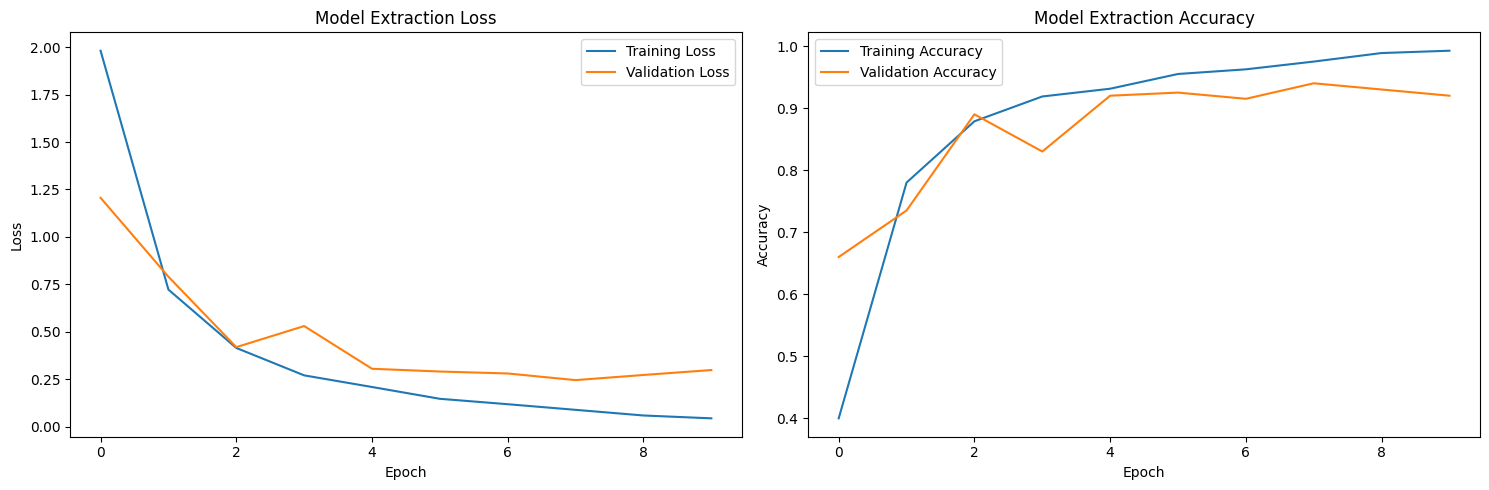

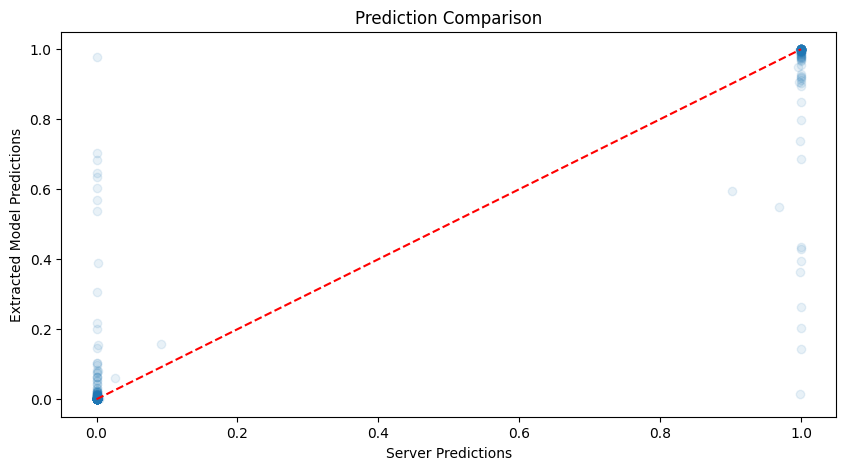

In [17]:
# Visualize extraction performance
attack.visualize_extraction(history)

# Visualize prediction comparison
attack.visualize_predictions(results)

In [18]:
# Save the extracted model
attack.extraction_model.save('models/extracted_model.keras')
print("Extracted model saved as 'extracted_model.keras'")

Extracted model saved as 'extracted_model.keras'


In [22]:
def load_extracted_model(self, model_path='models/extracted_model.keras'):
    """Load the extracted model from disk."""
    print("Loading extracted model...")
    return tf.keras.models.load_model(model_path)


In [23]:
def load_test_data(self, test_size=100):
    """Load and preprocess MNIST test data."""
    (_, _), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_test = x_test.astype('float32') / 255.0
    x_test = x_test.reshape(-1, 28, 28, 1)
    
    test_indices = np.random.choice(len(x_test), test_size, replace=False)
    return x_test[test_indices], y_test[test_indices]


In [24]:
def get_server_predictions(self, test_images):
    """Query the server for predictions on test images."""
    server_preds = []
    print("Getting server predictions...")
    
    for image in tqdm(test_images):
        response = requests.post(
            self.server_url, 
            json={'image': image.reshape(28, 28).tolist()}
        )
        if response.status_code == 200:
            server_preds.append(response.json()['prediction'])
    
    return np.array(server_preds)


In [25]:
def get_extracted_predictions(self, extracted_model, test_images):
    """Get predictions from the extracted model."""
    print("\nGetting extracted model predictions...")
    extracted_preds = extracted_model.predict(test_images)
    return np.argmax(extracted_preds, axis=1)


In [26]:
def calculate_metrics(self, server_preds, extracted_preds, true_labels):
    """Calculate accuracy and agreement metrics."""
    server_accuracy = np.mean(server_preds == true_labels)
    extracted_accuracy = np.mean(extracted_preds == true_labels)
    agreement = np.mean(server_preds == extracted_preds)

    print("\nAccuracy Results:")
    print(f"Server Model Accuracy: {server_accuracy:.4f}")
    print(f"Extracted Model Accuracy: {extracted_accuracy:.4f}")
    print(f"Model Agreement Rate: {agreement:.4f}")
    
    return {
        'server_accuracy': server_accuracy,
        'extracted_accuracy': extracted_accuracy,
        'agreement_rate': agreement
    }


In [27]:
def print_example_predictions(self, true_labels, server_preds, extracted_preds):
    """Print the first few example predictions."""
    print("\nExample Predictions (first 10 images):")
    print("True Label | Server Prediction | Extracted Prediction")
    print("-" * 50)
    
    for i in range(10):
        print(f"{true_labels[i]:^10d} | {server_preds[i]:^16d} | {extracted_preds[i]:^20d}")


In [28]:
def visualize_predictions(self, test_images, true_labels, server_preds, extracted_preds):
    """Visualize example predictions with images."""
    plt.figure(figsize=(15, 4))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(test_images[i].reshape(28, 28), cmap='gray')
        plt.title(f'True: {true_labels[i]}\nS: {server_preds[i]}\nE: {extracted_preds[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [29]:
def visualize_confusion_matrix(self, server_preds, extracted_preds):
    """Plot a confusion matrix comparing server and extracted predictions."""
    plt.figure(figsize=(8, 8))
    confusion = np.zeros((10, 10))
    
    for s, e in zip(server_preds, extracted_preds):
        confusion[s][e] += 1
    
    plt.imshow(confusion, cmap='Blues')
    plt.colorbar()
    plt.title('Confusion Matrix: Server vs Extracted Predictions')
    plt.xlabel('Extracted Model Predictions')
    plt.ylabel('Server Model Predictions')

    for i in range(10):
        for j in range(10):
            plt.text(j, i, int(confusion[i][j]), ha='center', va='center')

    plt.show()


In [30]:
def test_predictions(self):
    """Run the full testing process for the extracted model."""
    extracted_model = self.load_extracted_model()
    test_images, test_labels = self.load_test_data()

    server_preds = self.get_server_predictions(test_images)
    extracted_preds = self.get_extracted_predictions(extracted_model, test_images)

    metrics = self.calculate_metrics(server_preds, extracted_preds, test_labels)
    
    self.print_example_predictions(test_labels, server_preds, extracted_preds)
    self.visualize_predictions(test_images, test_labels, server_preds, extracted_preds)
    self.visualize_confusion_matrix(server_preds, extracted_preds)
    
    return {
        **metrics,
        'server_preds': server_preds,
        'extracted_preds': extracted_preds,
        'true_labels': test_labels
    }


In [31]:
ServerModelExtractionAttack.load_extracted_model = load_extracted_model
ServerModelExtractionAttack.load_test_data = load_test_data
ServerModelExtractionAttack.get_server_predictions = get_server_predictions
ServerModelExtractionAttack.get_extracted_predictions = get_extracted_predictions
ServerModelExtractionAttack.calculate_metrics = calculate_metrics
ServerModelExtractionAttack.print_example_predictions = print_example_predictions
ServerModelExtractionAttack.visualize_predictions = visualize_predictions
ServerModelExtractionAttack.visualize_confusion_matrix = visualize_confusion_matrix
ServerModelExtractionAttack.test_predictions = test_predictions


Loading extracted model...
Getting server predictions...


  0%|          | 0/100 [00:00<?, ?it/s]


Getting extracted model predictions...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step 

Accuracy Results:
Server Model Accuracy: 0.9900
Extracted Model Accuracy: 0.9500
Model Agreement Rate: 0.9600

Example Predictions (first 10 images):
True Label | Server Prediction | Extracted Prediction
--------------------------------------------------
    9      |        9         |          9          
    1      |        1         |          1          
    7      |        7         |          7          
    4      |        4         |          9          
    8      |        8         |          8          
    9      |        9         |          9          
    0      |        0         |          0          
    8      |        8         |          8          
    6      |        6         |          6          
    4      |        4         |          6          


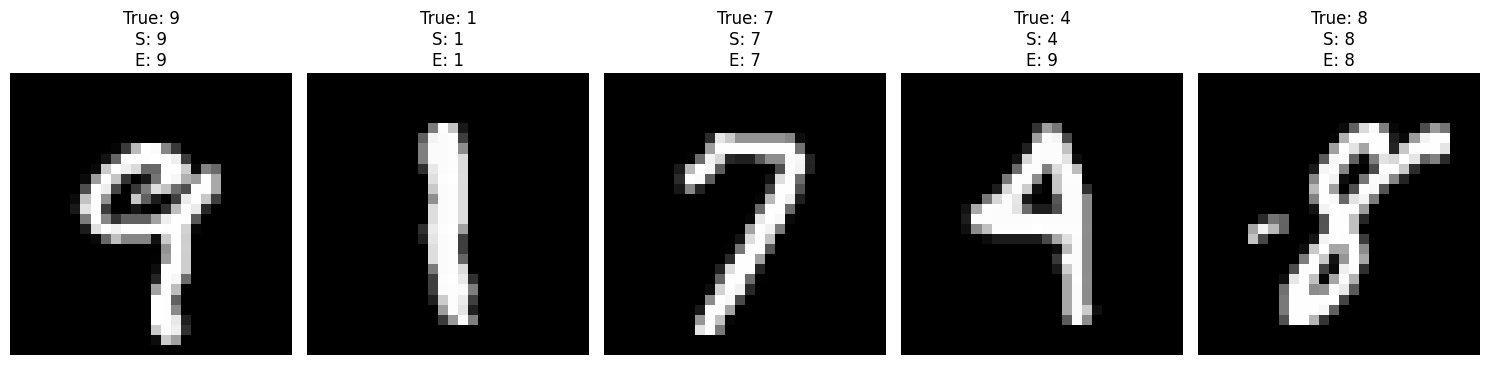

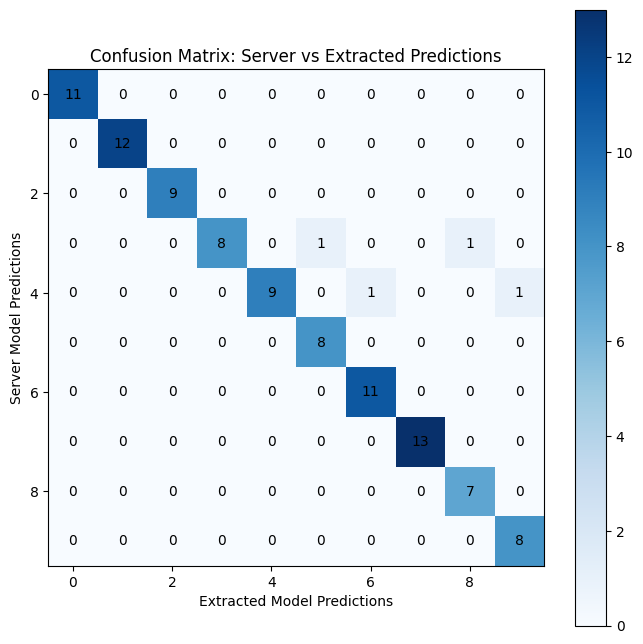

In [32]:
attack = ServerModelExtractionAttack()
test_results = attack.test_predictions()
